## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pcshrink

plt.style.use("ggplot")

## Functions

In [3]:
def get_genotype_matrix(geno_path, n, p):
    """Gets the genotype matrix stored as a
    numpy array
    """
    # read the geno file
    with open(geno_path, "r") as f:
        matstr = f.read().replace("\n", "")

    # convert to long array
    ys = np.fromstring(matstr, dtype=np.int8) - 48
    
    # reshape to p x n matrix
    Y = ys.reshape(p, n).astype(np.float32)
    
    # replace 9s with nans
    Y[Y == 9] = np.nan
    
    return(Y)

## Experiment

Read the data ...

In [63]:
n = 60
p = 120631
k = 2

#### genoty mat ####
Y = get_genotype_matrix("../data/yfhx.geno", n=60, p=120631)
print(Y.shape)

#### ind df ####
ind_df = pd.read_table("../data/yfhx.ind", sep="\s+", header=None)
ind_df.columns = ["ind", "sex", "clst"]
print(ind_df.head())

#### snp df ####
snp_df = pd.read_table("../data/yfhx.snp", sep="\s+", header=None)
snp_df.columns = ["snp", "chrom", "cm", "pos", "a1", "a2"]
auto_idx = snp_df[snp_df["chrom"] <= 22].index
print(auto_idx.shape)
print(snp_df.head())

(120631, 60)
         ind sex    clst
0  HGDP00511   M  French
1  HGDP00512   M  French
2  HGDP00513   F  French
3  HGDP00514   F  French
4  HGDP00515   M  French
(120083,)
             snp  chrom        cm      pos a1 a2
0  Affx-15871758      1  0.025727   949654  A  G
1   Affx-3979904      1  0.026674  1048955  A  G
2   Affx-4572154      1  0.029335  1156131  T  C
3   Affx-4575207      1  0.029356  1157547  T  C
4   Affx-4584321      1  0.029391  1161780  C  T


/project/jnovembre/jhmarcus/src/miniconda3/envs/pcshrink_e/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


Split inds into test / train ...

In [64]:
test_idx = np.array([x[-1] == "X" for x in ind_df["clst"].values])
Y_train = Y[auto_idx, :][:, ~test_idx]
Y_test = Y[auto_idx, :][:, test_idx]

ind_train_df = ind_df.iloc[~test_idx]
ind_test_df = ind_df.iloc[test_idx]

Normalize the data and run intial PCA

In [85]:
norm = pcshrink.Normalizer(Y_train, eps=0.05, scale_type="patterson")
pc = pcshrink.ShrinkageCorrector(norm.Y, k=k)
L = pc.L

Estimate the shrinkage correction factor using jackknife

In [86]:
pc.jackknife(q=k, o=5, downdate=False)
print(pc.tau)

holding out sample 0
holding out sample 5
holding out sample 10
holding out sample 15
holding out sample 20
holding out sample 25
[1.25870347 1.3992341 ]


Fast rank-1 downdate estimator ...

In [87]:
pc.jackknife(q=k, o=5, downdate=True)
print(pc.tau)

holding out sample 0
holding out sample 5
holding out sample 10
holding out sample 15
holding out sample 20
holding out sample 25
[1.25870342 1.39923455]


Normalize test data with mean and scale of training dataset and project on to training pcs ...

In [88]:
Z_test = (Y_test[norm.snp_idx, :] - norm.mu) / norm.s
L_test = np.empty((int(n/2), k))
for i in range(int(n/2)):
    L_test[i, :] = pc.lstsq_project(Z_test[:, i], k)

/project/jnovembre/jhmarcus/src/miniconda3/envs/pcshrink_e/lib/python3.7/site-packages/pcshrink/correct.py:276: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  l = np.linalg.lstsq(F, y)[0]


Plot the results!

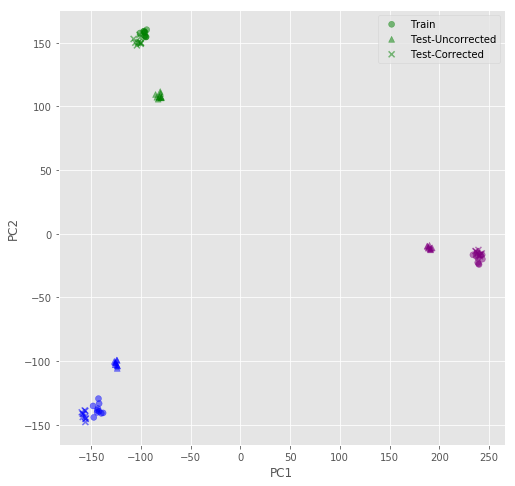

In [89]:
plt.figure(figsize=(8,8))

c_dict = {"French": "green", "Yoruba": "purple", "Han": "blue"}
c_train = [c_dict[x] for x in ind_train_df["clst"].values]
c_test =  [c_dict[x.strip("X")] for x in ind_test_df["clst"].values]

plt.scatter(L[:, 0], L[:, 1], c=c_train, label="Train", alpha=.5)
plt.scatter(L_test[:, 0], L_test[:, 1], c=c_train, label="Test-Uncorrected", marker="^", alpha=.5)
plt.scatter(pc.tau[0] * L_test[:, 0], 
            pc.tau[1] * L_test[:, 1], 
            c=c_train, label="Test-Corrected", marker="x", alpha=.5)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

## Compare to EigenStrat

`TODO`